In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/kickstarter_projects1.csv')

In [3]:
df.tail()

,ID,Name,Category,Subcategory,Country,Launched,Deadline,Goal,Pledged,Backers,State
374848,1486845240,Americas Got Talent - Serious MAK,Music,Hip-Hop,United States,2018-01-02 14:13:09,2018-01-16,500,0,0,Live
374849,974738310,EVO Planner: The World's First Personalized Fl...,Design,Product Design,United States,2018-01-02 14:15:38,2018-02-09,15000,269,8,Live
374850,2106246194,"Help save La Gattara, Arizona's first Cat Cafe!",Food,Food,United States,2018-01-02 14:17:46,2018-01-16,10000,165,3,Live
374851,1830173355,Digital Dagger Coin,Art,Art,United States,2018-01-02 14:38:17,2018-02-01,650,7,1,Live
374852,1339173863,Spirits of the Forest,Games,Tabletop Games,Spain,2018-01-02 15:02:31,2018-01-26,24274,4483,82,Live


In [4]:
df['State'].unique()

array(['Failed', 'Successful', 'Canceled', 'Suspended', 'Live'],
      dtype=object)

In [5]:
df['Country'].unique()

array(['United States', 'United Kingdom', 'Canada', 'Australia',
       'New Zealand', 'Netherlands ', 'Sweden', 'Denmark', 'Norway',
       'Ireland', 'Germany', 'France', 'Spain', 'Belgium', 'Italy',
       'Switzerland', 'Austria', 'Luxembourg', 'Singapore', 'Hong Kong',
       'Mexico', 'Japan'], dtype=object)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374853 entries, 0 to 374852
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ID           374853 non-null  int64 
 1   Name         374853 non-null  object
 2   Category     374853 non-null  object
 3   Subcategory  374853 non-null  object
 4   Country      374853 non-null  object
 5   Launched     374853 non-null  object
 6   Deadline     374853 non-null  object
 7   Goal         374853 non-null  int64 
 8   Pledged      374853 non-null  int64 
 9   Backers      374853 non-null  int64 
 10  State        374853 non-null  object
dtypes: int64(4), object(7)
memory usage: 31.5+ MB


<Axes: xlabel='State', ylabel='count'>

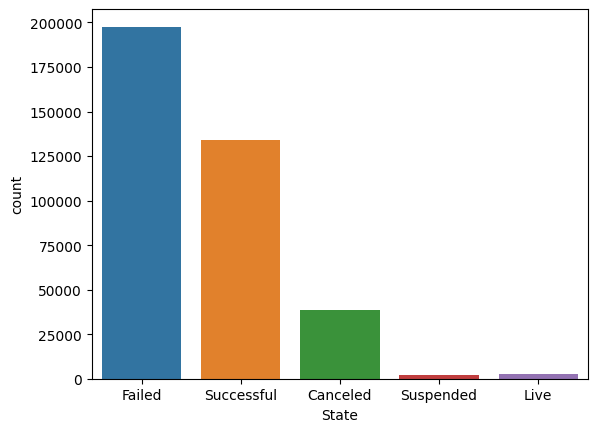

In [7]:
cat_counts = df['State'].value_counts(normalize = True)
sns.countplot(x='State', data = df)

In [8]:
cat_counts

State
Failed        0.527169
Successful    0.357076
Canceled      0.103377
Live          0.007464
Suspended     0.004914
Name: proportion, dtype: float64

In [9]:
# Dropping Name and ID column
df = df.drop(['Name', 'ID'], axis=1)

In [10]:
# Converting dates to datetime
df['Launched'] = pd.to_datetime(df['Launched'])
df['Deadline'] = pd.to_datetime(df['Deadline'])

# Creating a column for the days the kickstarter was live
df['live_days'] = (df['Deadline']-df['Launched']).dt.days
df['year'] = (df['Deadline']).dt.year


In [11]:
# Removing Live and Suspended rows, since they are uncategorizable 
# and only removes a small % of df
df = df[df['State'] != 'Live']
df = df[df['State'] != 'Suspended']
df.State.unique()

array(['Failed', 'Successful', 'Canceled'], dtype=object)

<Axes: xlabel='year'>

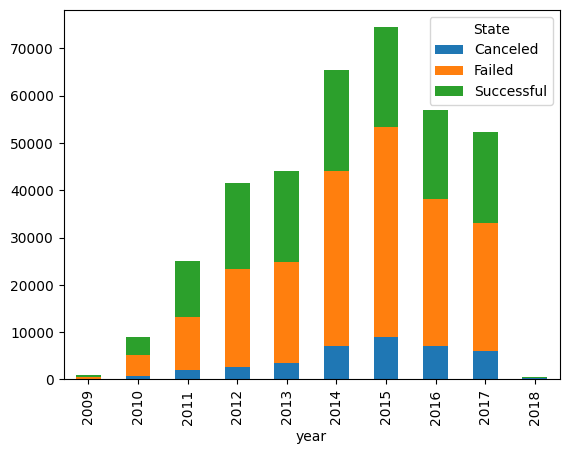

In [12]:
# Creating a year column
year_state_df = df.groupby(['year', 'State']).size().unstack(fill_value=0)

# Plotting 
year_state_df.plot(kind='bar', stacked = True)

In [13]:
# Making everything else than succesful = 0
df['State'] = df['State'].map({'Successful': 1, 'Failed': 0, 'Canceled': 0})
df['State'].unique()

array([0, 1], dtype=int64)

In [14]:
# Percentage of success and fail per year
year_state_df_percentage = year_state_df.div(year_state_df.sum(axis=1), axis=0) * 100
round(year_state_df_percentage, 2)

State,Canceled,Failed,Successful
year,,,
2009,11.97,45.45,42.57
2010,8.58,47.30,44.12
2011,8.33,44.70,46.97
2012,6.47,50.01,43.52
2013,8.10,48.40,43.50
2014,10.92,56.65,32.43
2015,12.07,59.62,28.31
2016,12.60,54.48,32.93
2017,11.43,51.64,36.93


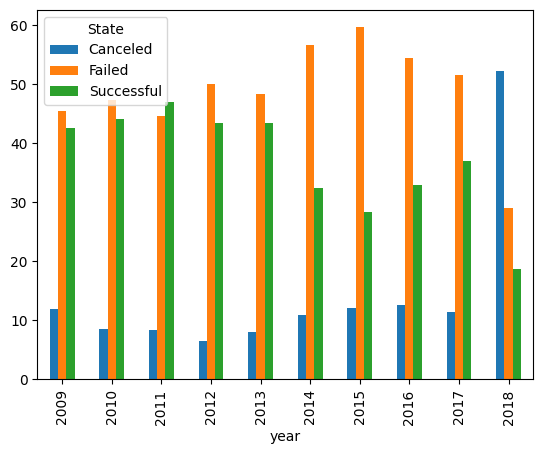

In [15]:
year_state_df_percentage.plot(kind='bar');

In [16]:
# Defining X and y
X = df.drop('State', axis=1)
y = df.State

In [17]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

In [18]:
# Defining num and cat featurs (removed 'Pledged', 'Backers','year') 
cat_features = ['Category', 'Subcategory', 'Country']
num_features = ['Goal','live_days']                
df['State'].unique()

array([0, 1], dtype=int64)

In [19]:
# Creating num and cat transformers using pipeline
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [20]:
# Columntransformer
preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num_features),
                  ('cat', cat_transformer, cat_features)])

# Pipeline with preprocessor and logistic regression
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(class_weight='balanced'))])

# Fitting the pipeline on training set
pipeline.fit(X_train, y_train)




Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Goal', 'live_days']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Category', 'Subcategory',
                                                   'Country'])])),
                ('classifier', LogisticRegression(class_weight='balanced'))])

In [21]:
# Predicting on Logreg model
y_pred = pipeline.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.63      0.69     70909
           1       0.51      0.68      0.58     40155

    accuracy                           0.65    111064
   macro avg       0.64      0.65      0.64    111064
weighted avg       0.68      0.65      0.65    111064

[[44446 26463]
 [12820 27335]]


In [22]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

class BaselineClassifier(BaseEstimator, ClassifierMixin):
    """
    Baseline model predicting everyone with a glucose value higher than 
    a threshold suffers from diabetes
    """
    def __init__(self, threshold=None):
        self.threshold = threshold
        
    def fit(self, X, y):
        # Compute the threshold as the mean of the 'Goal' column
        if self.threshold is None:
            self.threshold = np.mean(X['Goal'])
        return self
    
    def predict(self, X):
        # Assuming 'Goal' is the column you want to use for predictions
        predictions = [1 if goal_value > self.threshold else 0 for goal_value in X['Goal']]
        return np.array(predictions)

# Create an instance of the BaselineClassifier without specifying the threshold
baseline_model = BaselineClassifier()

# Fit the baseline model (computes the threshold during fitting)
baseline_model.fit(X_train, y_train)

# Make predictions using the baseline model
baseline_predictions = baseline_model.predict(X_test)

In [23]:
rf_pipeline = Pipeline(steps=
            [('preprocessor', preprocessor),('classifier',RandomForestClassifier
            (n_estimators=100, random_state=42, n_jobs = -1, verbose = 1, class_weight='balanced'))])

rf_pipeline.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.6min finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Goal', 'live_days']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Category', 'Subcategory',
                                                   'Country'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42, verbose=1))])

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished


              precision    recall  f1-score   support

           0       0.73      0.71      0.72     70909
           1       0.51      0.55      0.53     40155

    accuracy                           0.65    111064
   macro avg       0.62      0.63      0.62    111064
weighted avg       0.65      0.65      0.65    111064



<Axes: >

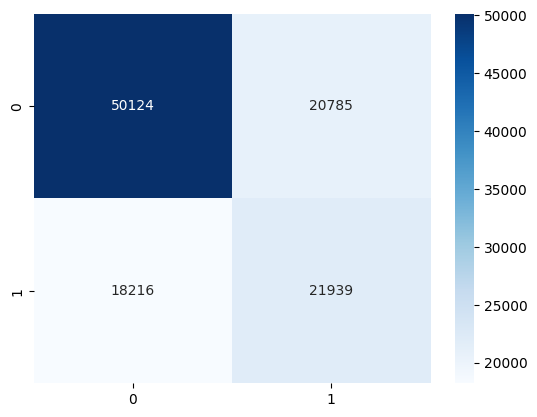

In [24]:
# Predicting on RandomForest
y_pred_rf = rf_pipeline.predict(X_test)

# Evaluation on RandomForest
print(classification_report(y_test, y_pred_rf))
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot = True, fmt = 'g', cmap = 'Blues')


In [25]:
# Balanced RandomForest
from sklearn.feature_selection import SelectFromModel
brf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(BalancedRandomForestClassifier())),
    ('classifier', BalancedRandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbose=1,
                                                  class_weight='balanced'))
])

brf_pipeline.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.7min finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Goal', 'live_days']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Category', 'Subcategory',
                                                   'Country'])])),
                ('feature_selection',
                 SelectFromModel(estimator=BalancedRandomForestClassifier())),
                ('classifier',
                 BalancedRandomForestClassifier(class_weight='balanced',
                                                n_jobs=-1, random_state=42,
                                                verbose=1))])

In [26]:
# Predicting on Balanced RandomForest
y_pred_brf = brf_pipeline.predict(X_test)

# Evaluation on Balanced RandomForest
print(classification_report(y_test, y_pred_brf))
#cm_brf = confusion_matrix(y_test, y_pred_brf)
#sns.heatmap(cm_brf, annot = True, fmt = 'g', cmap = 'Blues')

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.8s finished


              precision    recall  f1-score   support

           0       0.79      0.40      0.53     70909
           1       0.43      0.81      0.57     40155

    accuracy                           0.55    111064
   macro avg       0.61      0.61      0.55    111064
weighted avg       0.66      0.55      0.55    111064



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.3s finished


              precision    recall  f1-score   support

           0       0.93      0.48      0.63    165453
           1       0.51      0.94      0.66     93696

    accuracy                           0.65    259149
   macro avg       0.72      0.71      0.65    259149
weighted avg       0.78      0.65      0.64    259149



<Axes: >

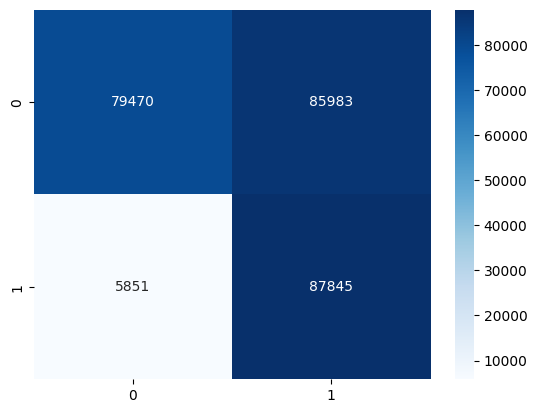

In [27]:
# Predicting on Balanced RandomForest
y_pred_brf_train = brf_pipeline.predict(X_train)

# Evaluation on Balanced RandomForest
print(classification_report(y_train, y_pred_brf_train))
cm_brf_train = confusion_matrix(y_train, y_pred_brf_train)
sns.heatmap(cm_brf_train, annot = True, fmt = 'g', cmap = 'Blues')

In [28]:
# XGboost
xg_pipeline = Pipeline(steps=
            [('preprocessor', preprocessor),('classifier',XGBClassifier())])

xg_param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7]
}


xg_grid = GridSearchCV(xg_pipeline, param_grid=xg_param_grid, cv=5, scoring='recall')

xg_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Goal',
                                                                          'live_days']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Category',
                                                                          'Subcategory',
                                                                          'C...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'classifier__learning_rate': [0.01, 0.1, 0.2],
                         'classifier__max_depth': [3, 5, 7],
                         'classifier__n_estimators': [50, 100, 200]},
             scoring='recall')

In [29]:
# Best model based on GridSearchCV
best_xg_model = xg_grid.best_estimator_

              precision    recall  f1-score   support

           0       0.73      0.85      0.78     70909
           1       0.62      0.44      0.51     40155

    accuracy                           0.70    111064
   macro avg       0.67      0.64      0.65    111064
weighted avg       0.69      0.70      0.69    111064



Text(50.722222222222214, 0.5, 'Actual')

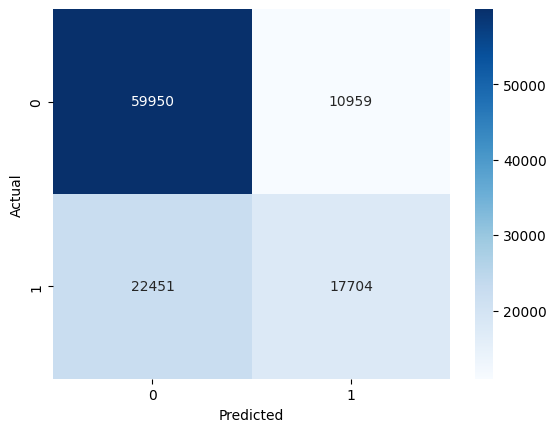

In [30]:
#Predicting on best XGBoost model
y_pred_xg = best_xg_model.predict(X_test)

# Evaluating on XGBoost
print(classification_report(y_test, y_pred_xg))
cm_xg = confusion_matrix(y_test, y_pred_xg)
sns.heatmap(cm_xg, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [31]:
# KNN pipeline and fit
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))])
knn_pipeline.fit(X_train, y_train)

# KNN predict
y_pred_knn = knn_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_knn))
print(confusion_matrix(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.71      0.77      0.74     70909
           1       0.53      0.46      0.49     40155

    accuracy                           0.66    111064
   macro avg       0.62      0.61      0.62    111064
weighted avg       0.65      0.66      0.65    111064

[[54624 16285]
 [21831 18324]]


In [32]:
# Predict probabilities for the test set on different models
y_prob_bs = pipeline.predict_proba(X_test)[:, 1]
y_prob_knn = knn_pipeline.predict_proba(X_test)[:, 1]
y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]
y_prob_xg = xg_grid.predict_proba(X_test)[:, 1]
y_prob_brf = brf_pipeline.predict_proba(X_test)[:, 1]
y_prob_baseline = baseline_model.predict_proba(X_test)[:, 1]

# ROC & auc for baseline
fpr_baseline, tpr_baseline, thresholds = roc_curve(y_test, y_prob_baseline)
auc_baseline = roc_auc_score(y_test, y_prob_baseline)

# ROC & auc for logreg
fpr_bs, tpr_bs, thresholds = roc_curve(y_test, y_prob_bs)
auc_base = roc_auc_score(y_test, y_prob_bs)

# ROC & auc for KNN
fpr_knn, tpr_knn, thresholds = roc_curve(y_test, y_prob_knn)
auc_knn = roc_auc_score(y_test, y_prob_knn)

# ROC & auc for RandomForest
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_prob_rf)
auc_rf = roc_auc_score(y_test, y_prob_rf)

# ROC & auc for BalancedRandomForest
fpr_brf, tpr_brf, thresholds = roc_curve(y_test, y_prob_brf)
auc_brf = roc_auc_score(y_test, y_prob_brf)

# ROC & auc for XGBoost
fpr_xg, tpr_xg, thresholds = roc_curve(y_test, y_prob_xg)
auc_xg = roc_auc_score(y_test, y_prob_xg)

plt.figure(figsize=(8, 8))
plt.plot(fpr_baseline, tpr_baseline, label=f'Baseline (AUC = {auc_baseline:.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.2f})')
plt.plot(fpr_bs, tpr_bs, label=f'LogReg (AUC = {auc_base:.2f})')
plt.plot(fpr_xg, tpr_xg, label=f'XGBoost (AUC = {auc_xg:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'RandomForest (AUC = {auc_rf:.2f})')
plt.plot(fpr_brf, tpr_brf, label=f'BalancedRandomForest (AUC = {auc_brf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guess')
plt.title('(ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.show()

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.1s finished


AttributeError: 'BaselineClassifier' object has no attribute 'predict_proba'